In [1]:
import pickle
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [2]:
DATASET = 'twitter'
if DATASET == 'twitter': ext = -3; q = 1e6; q_baseline = 1e8; q_flagratio = 1e14; width=12; optimal_idx = 47; oracle_idx = 47; flagratio_idx = 3; baseline_idx = 6; threshold_idx = 5;
else: ext = -4; q = 1e6; q_baseline = 1e8; q_flagratio = 1e12; width = 20; optimal_idx = 49; oracle_idx = 49; flagratio_idx = 6; baseline_idx = 44; threshold_idx = 10;

In [3]:
file_hist = pickle.load(open('./../%s/results/file_hist.pkl' % (DATASET), 'rb'))
target_files = pickle.load(open('./../%s/results/target_files.pkl' %(DATASET) , 'rb'))


In [4]:
file_data = dict()
for file in target_files:
    file_pkl = file[:ext] + 'pkl'
    data = pickle.loads(open('./../%s/exposure_data/' % (DATASET)  + file_pkl  , 'rb').read())
    file_data[file_pkl] = data

In [5]:
def misinfo_reduction(files, taus, T_start, T_end):
    total_events = 0
    reduced_events = 0
    for file, tau in zip(files, taus):        
        if file[0] == 'R':
            data = file_data[file[:ext] + 'pkl' ]
            if tau != None:
                tau = tau + np.min(data[:, 1])
            times = data[:, 1]
            times_small = times[(times < T_end) & (times > T_start)]
            total_events += len(times_small)
            if tau != None:
                reduced_events += len(times_small[times_small < tau])
            else:
                reduced_events += len(times_small)
    return reduced_events

def total_users(files, T_start, T_end):
    total_events = 0
    for file in files:        
        if file[0] == 'R':
            data = file_data[file[:ext] + 'pkl' ]
            times = data[:, 1]
            times_small = times[(times < T_end) & (times > T_start)]
            total_events += len(times_small)
    return total_events

In [6]:
iter = 50

file_data = dict()
for file in target_files:
    file_pkl = file[:ext] + 'pkl'
    data = pickle.loads(open('./../%s/exposure_data/' % (DATASET) + file_pkl, 'rb').read())
    file_data[file_pkl] = data

In [7]:
T_start = min([min(v[:, 1]) for k, v in list(file_data.items()) if k[0] == 'R'])
T_end = max([max(v[:, 1]) for k, v in list(file_data.items()) if k[0] == 'R'])
T_end = T_end * 1.01
alpha = 100

In [8]:
q_file_optimal = pickle.load(open('./../%s/results/q_file_Optimal_alpha_%d.pkl' % (DATASET, int(alpha)), 'rb'))
q_file_oracle = pickle.load(open('./../%s/results/q_file_Oracle_alpha_%d.pkl' % (DATASET, int(alpha)), 'rb'))
q_file_threshold = pickle.load(open('./../%s/results/q_file_threshold_alpha_%d.pkl' %(DATASET, int(alpha)) , 'rb'))
q_file_baseline = pickle.load(open('./../%s/results/q_file_Baseline_alpha_%d.pkl' %(DATASET, int(alpha)), 'rb'))
q_file_flagratio = pickle.load(open('./../%s/results/q_file_Flagratio_alpha_%d.pkl' %(DATASET, int(alpha)), 'rb'))
n_bins = 10


In [9]:
def return_results(q_file, q):
    results = []

    for TT_end in np.linspace(T_start, T_end, n_bins):
        if q_file != None:
            files = list(q_file[q].keys())
            taus_long = np.array([q_file[q][file] for file in files])
        else:
            files = target_files
        misinfo_reducs = []
        for ii in range(iter):
            if q_file != None:
                taus = taus_long[:, ii]
                misinfo_reduc = misinfo_reduction(files, taus, T_start, TT_end)
            else:
                misinfo_reduc = total_users(files, T_start, TT_end)
            misinfo_reducs.append(misinfo_reduc)
        results.append(np.mean(misinfo_reducs))

    results = np.array(results)
    results_delta = np.array([results[i + 1] - results[i] for i in range(len(results) - 1)])

    return((results, results_delta))

In [10]:
results_oracle, results_oracle_delta = return_results(q_file_oracle, q)
results_optimal, results_optimal_delta = return_results(q_file_optimal, q)
results_threshold, results_threshold_delta = return_results(q_file_threshold, q)
results_baseline, results_baseline_delta = return_results(q_file_baseline, q_baseline)
results_flagratio, results_flagratio_delta = return_results(q_file_flagratio, q_flagratio)
results_total, results_total_delta = return_results(None, q)

In [11]:
sns.set_style("ticks",{'axes.grid': False})
sns.set_context("paper", font_scale=2., rc={"lines.linewidth": 3,
                                           'lines.markersize': 12})


In [12]:
palette = sns.color_palette()
color1 =  (0.21568627450980393, 0.47058823529411764, 0.7490196078431373)
color2 = '#666666'
color3 = '#444444'

x = (np.linspace(T_start, T_end, n_bins) - T_start) / (60 * 60 * 24)
delta_x = x[3] - x[2]

In [13]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 2, 3]) 

In [14]:
ax1 = plt.subplot(gs[0])

In [15]:
ax1.plot(x, results_total, color= color3, label='Total')
ax1.plot(x, results_flagratio, color=color2, label='Flag Ratio', linestyle='-.', marker='D')
ax1.plot(x, results_threshold, color=color2, label='Flag Sum', linestyle='--', marker='|')
ax1.plot(x, results_baseline, color=color2, label='Exposure', linestyle=':', marker='<')
ax1.plot(x, results_optimal, color=color1, label='Curb', marker='o')
ax1.plot(x, results_oracle, color=color1, label='Oracle', linestyle='-.', marker='^')
ax1.set_xlim((x[0], x[-1] + delta_x))

ax2 = plt.subplot(gs[1], sharex=ax1)

In [16]:
def return_taus(q_file, q, i):
    taus = []
    files = list(q_file[q].keys())
    for file in files:
        if file[0] == 'R':
            tau = q_file[q][file][i]
            initial_t = np.min(file_data[file[:ext] + 'pkl'][:, 1])
            if tau != None:
                taus.append(tau + initial_t)
    return(taus)

In [17]:
flagratio_taus = return_taus(q_file_flagratio, q_flagratio, flagratio_idx)
threshold_taus = return_taus(q_file_threshold, q, threshold_idx)
baseline_taus = return_taus(q_file_baseline, q_baseline, baseline_idx)
optimal_taus = return_taus(q_file_optimal, q, optimal_idx)
oracle_taus = return_taus(q_file_oracle, q, oracle_idx)


In [18]:
ax2.scatter( (threshold_taus - T_start) / (60 * 60 * 24) , np.ones(len(threshold_taus)) * 5, marker='D', color=color2, s=30)
ax2.scatter( (flagratio_taus - T_start) / (60 * 60 * 24) , np.ones(len(flagratio_taus)) * 4, marker='|', color=color2, s=30)
ax2.scatter( (baseline_taus - T_start) / (60 * 60 * 24) , np.ones(len(baseline_taus)) * 3, marker='<', color=color2, s=30)
ax2.scatter( (optimal_taus - T_start) / (60 * 60 * 24) , np.ones(len(optimal_taus)) * 2, marker='o', color=color1, s=30)
ax2.scatter( (oracle_taus - T_start) / (60 * 60 * 24) , np.ones(len(oracle_taus)) * 1, marker='^', color=color1, s=30)
_ = ax2.set_xlim((x[0], x[-1] + delta_x))

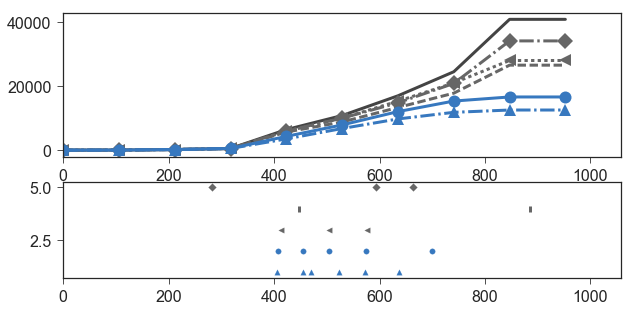

In [19]:
fig

In [20]:
ax3 = plt.subplot(gs[2], sharex=ax1)

ax3.bar(delta_x*0.5 + x[:-1] - 2.5*width, results_total_delta, color= color3, width=width, label='Total', edgecolor=color2, alpha=0.9, lw=1.5)
ax3.bar(delta_x*0.5 + x[:-1] - 1.5*width, results_flagratio_delta, color= 'none', width=width, label='Flag Ratio', edgecolor=color2, hatch="\\",lw=1.5)
ax3.bar(delta_x*0.5 + x[:-1] - 0.5*width, results_threshold_delta, color=color3, width=width, label='Flag Sum', edgecolor=color2, alpha=0.7, hatch="//", lw=1.5, zorder = 0)
ax3.bar(delta_x*0.5 + x[:-1] + 0.5*width, results_baseline_delta, color='none', width=width, label='Exposure', edgecolor=color2, hatch="+", lw=1.5, zorder = 0)
ax3.bar(delta_x*0.5 + x[:-1] + 1.5*width, results_optimal_delta, color=color1, width=width, label='Curb', alpha=0.9)
_ = ax3.bar(delta_x*0.5 + x[:-1] + 2.5*width, results_oracle_delta, color='none', width=width, label='Oracle', edgecolor=color1, hatch="x", lw=1.5, zorder = 0)

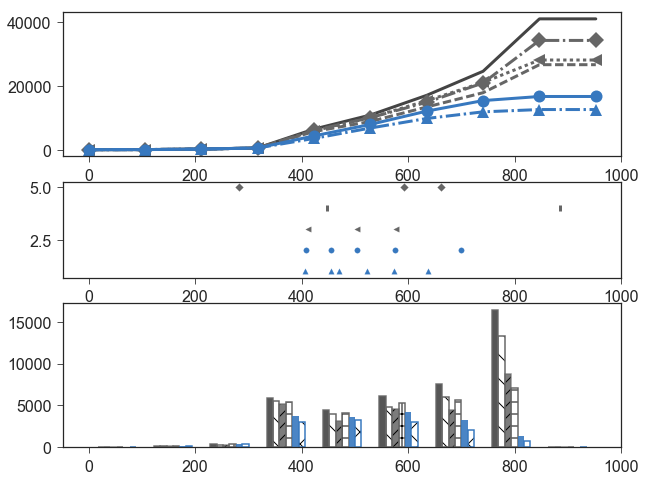

In [21]:
fig

In [22]:
sns.despine(ax=ax1, right=True, left=False, top=True)
sns.despine(ax=ax3, right=True, left=False, top=False)
sns.despine(ax=ax2, right=True, left=True, top=True, bottom=True)

In [23]:
ax3.set_xlabel('Time (days)')
ax1.set_ylabel('# Users')
ax3.set_ylabel('# Users')
ax3.spines['top'].set_color('#aaaaaa')
ax1.spines['bottom'].set_color('#aaaaaa')

In [24]:
xticklabels = ax1.get_xticklabels()  + ax2.get_xticklabels()
_ = plt.setp(xticklabels, visible=False)

In [25]:
xticks = ax3.get_xticks()
_ = ax3.set_xticks(xticks[::2])

In [26]:
ax1.legend(loc=(0.025, 0.15))
ax3.legend(loc=(0.025, 0.15))
ax2.get_xaxis().set_visible(False)
ax2.xaxis.grid(True)
labels = ['', 'Oracle', 'Curb', 'Exposure', 'Flag sum', 'Flag ratio', '']
ax2.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax2.set_yticklabels(labels)
_ = ax2.set_ylim((0.9, 5.25))

In [27]:
ax1.xaxis.set_tick_params(width=0)
ax3.set_xlim((x[0], x[-1] + delta_x))

fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

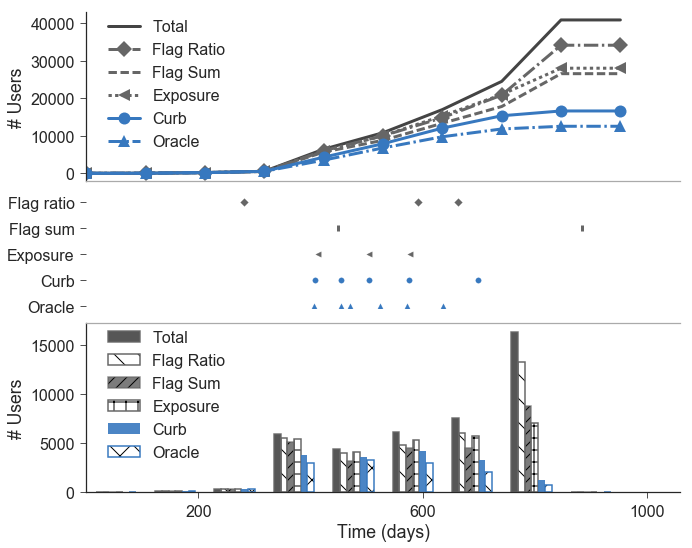

In [28]:
fig